# Malaria predictor: Image classification problem

# Working with Azure ML Experiments

Once we have trained a model in an experiment on Azure ML Services, the model artifacts and some results are stored in our Azure ML workspace in Azure. In this notebook we will show how we can retrieve our last experiment, check the evaluation results and load the model artifacts to be registered as model in the Azure ML workspace. Then we can deploy a container with that model to be publish for inference purposes.



## Importing common libraries 

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Creating the global variables for workspace

We need to set the the variables SUBSCRIPTION_ID, RECOURCE GROUP, WORKSPACE NAME and REGION to identify where our interested experiment is located.

In [2]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)


subscription_id = os.getenv("SUBSCRIPTION_ID", default="83674078-c3fc-41e3-9cf6-93f29065e2a4")
resource_group = os.getenv("RESOURCE_GROUP", default="CapstoneIA")
workspace_name = os.getenv("WORKSPACE_NAME", default="MalariaCNNKeras")
workspace_region = os.getenv("WORKSPACE_REGION", default="northeurope")

#Define the experiment run to retrieve and show
# We want the last experiment
selected_run='last'
results_path='results'

Azure ML SDK Version:  1.0.45


In [3]:

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except:
    print("Workspace not accessible. Creating a new workspace below")
    # Create the workspace using the specified parameters
    ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
    ws.get_details()


Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FYQF5UF8U to authenticate.
Interactive authentication successfully completed.
Workspace configuration succeeded. Skip the workspace creation steps below


## Get the last run of the experiment

In [6]:
from azureml.core import Experiment
# Get the list of experments in our workspace
exp = Experiment(workspace=ws, name='speech')
print(exp.name)
print(exp.list(ws))


speech
[Experiment(Name: malaria,
Workspace: MalariaCNNKeras), Experiment(Name: speech,
Workspace: MalariaCNNKeras)]


We have a list with all the experiments in our workspace, now we want to select the last one

In [7]:
# Get the last run of the experiment
runs=exp.get_runs()
if str(selected_run)=='last':
    run= list(runs)[0]
else:
    run=list(runs)[selected_run-1]
    
print('Run: ',run.number)


WARNING - Run Number's semantics may be modified in the future


Run:  15


In [8]:
run.properties

{'azureml.runsource': 'experiment',
 'ContentSnapshotId': 'c983b517-5a33-44f4-b4c7-fe868664119e',
 'AzureML.DerivedImageName': 'azureml/azureml_d11eca37f102303834454016a14b7700'}

Lets show the metrics from the training process

In [9]:
metrics = run.get_metrics()

In [10]:
print('Training Loss: ',metrics['Loss'][len(metrics['Loss'])-1])
print('Training Acc: ',metrics['Accuracy'][len(metrics['Accuracy'])-1])
print('Final test loss: ',metrics['Final test loss'])
print('Final test accuracy: ',metrics['Final test accuracy'])

Training Loss:  10.586494513920375
Training Acc:  0.3431919642857143


KeyError: 'Final test loss'

In [9]:
run.download_file('Accuracy vs Loss.png',results_path)

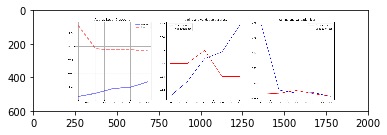

In [10]:
import matplotlib.image as mpimg

img=mpimg.imread(results_path+'/Accuracy vs Loss.png')
imgplot = plt.imshow(img)
plt.show()

## Download the saved model
In the training script, the Keras model is saved into two files, model.json and model.h5, in the outputs/models folder on the cluster AmlCompute node. Azure ML automatically uploaded anything written in the ./outputs folder into run history file store. Subsequently, we can use the run object to download the model files. They are under the the outputs/model folder in the run history file store, and are downloaded into a local folder named model.

In [8]:
# create a model folder in the current directory
os.makedirs('./model', exist_ok=True)
# we check the files in the outputs folder contained in the model folder and download them
for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

## Register the model

We can registry the model generated in the last experiment in our model repository, this allow us to containerized the model and make it publiclly accesible for inference. 

In [ ]:
model = run.register_model(model_name='malaria_cnn', model_path='outputs/model')

## Cancel an experiment

In [11]:
run.cancel()